# Solving Machine Learning Problems

In [5]:
!pip install 'sentencepiece==0.1.91' --force-reinstall
!pip install transformers
!pip install dgl
!pip install torchvision

  Using cached sentencepiece-0.1.91-cp38-cp38-manylinux1_x86_64.whl (1.1 MB)
  Attempting uninstall: sentencepiece
    Found existing installation: sentencepiece 0.1.91
    Uninstalling sentencepiece-0.1.91:
      Successfully uninstalled sentencepiece-0.1.91
     |████████████████████████████████| 4.3 MB 4.9 MB/s eta 0:00:01
     |████████████████████████████████| 17.4 MB 4.0 MB/s eta 0:00:01


In [1]:
from transformers import T5Tokenizer,T5Model

In [2]:
## Needs: pytorch, dgl, transformers, Python>=3.7

from copy import copy
from tqdm import tqdm, trange
import itertools

import random
import math
import numpy as np
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F

import dgl
from dgl.nn import GraphConv
false = False
true = True
NaN = float("NaN")
import matplotlib.pyplot as plt
from collections import Counter

from util import setup, check_match, evaluate_prefix_expression, sub_nP # get_quant_cells

Using backend: pytorch


# Converting Inputs to Torch Tensors

In [3]:
def tensorize_data(train_data, test_data):
    print(f"Number of items: {len(train_data)+len(test_data)}")
    for d in tqdm(itertools.chain(train_data, test_data)):
        d['in_idxs'] = torch.tensor([in_vocab.token2idx.get(x, in_vocab.unk) for x in d['in_tokens']])
        d['out_idxs'] = torch.tensor([out_vocab.token2idx.get(x, out_vocab.unk) for x in d['out_tokens']])
        d['n_in'] = n_in = len(d['in_idxs'])
        d['n_out'] = len(d['out_idxs'])
        d['n_nP'] = n_nP = len(d['nP'])
        d['nP_in_mask'] = mask = torch.zeros(n_in, dtype=torch.bool)
        mask[d['nP_positions']] = True
        d['nP_out_mask'] = mask = torch.zeros(n_max_nP, dtype=torch.bool)
        mask[:n_nP] = True
        d['qcomp_edges'] = get_quantity_comparison_edges(d)
        d['qcell_edges'] = get_quantity_cell_edges(d)

def get_quantity_comparison_edges(d):
    quants = [float(x) for x in d['nP']]
    quant_positions = d['nP_positions']
#     assert max(quant_positions) < d['n_in']
    adj_matrix = torch.eye(d['n_in'], dtype=np.bool)
    for x, x_pos in zip(quants, quant_positions):
        for y, y_pos in zip(quants, quant_positions):
            adj_matrix[x_pos, y_pos] |= x > y
    """
    Convert the adjacency matrix of the directed graph into a tuple of (src_edges, dst_edges), which
    is the input format of dgl.graph (see https://docs.dgl.ai/generated/dgl.graph.html).
    Hint: check out the 'nonzero' function
    """
    return adj_matrix.nonzero(as_tuple=True)

def get_quantity_cell_edges(d):
    in_idxs = d['in_idxs']
    quant_positions = d['nP_positions']
    quant_cell_positions = d['quant_cell_positions']
    assert max(quant_cell_positions) < d['n_in']
    word_cells = set(quant_cell_positions) - set(quant_positions)
    adj_matrix = torch.eye(d['n_in'], dtype=torch.bool)
    for w_pos in word_cells:
        for q_pos in quant_positions:
            if abs(w_pos - q_pos) < 4:
                adj_matrix[w_pos, q_pos] = adj_matrix[q_pos, w_pos] = True
    pos_idxs = in_idxs[quant_cell_positions]
    for idx1, pos1 in zip(pos_idxs, quant_cell_positions):
        for idx2, pos2 in zip(pos_idxs, quant_cell_positions):
            if idx1 == idx2:
                adj_matrix[pos1, pos2] = adj_matrix[pos2, pos1] = True
    """
    Convert the adjacency matrix of the directed graph into a tuple of (src_edges, dst_edges), which
    is the input format of dgl.graph (see https://docs.dgl.ai/generated/dgl.graph.html).
    Hint: check out the 'nonzero' function
    """
    return adj_matrix.nonzero(as_tuple=True)

# Model

In [18]:
class TransformerAttention(nn.Module):
    """
    Used in Transformer Block
    """
    def __init__(self):
        super().__init__()
        self.qkv = nn.Linear(n_hid, n_head * (n_k * 2 + n_v))
        self.out = nn.Linear(n_head * n_v, n_hid)

    def forward(self, x, mask=None):
        n_batch, n_batch_max_in, n_hid = x.shape
        q_k_v = self.qkv(x).view(n_batch, n_batch_max_in, n_head, 2 * n_k + n_v).transpose(1, 2)
        q, k, v = q_k_v.split([n_k, n_k, n_v], dim=-1)

        q = q.reshape(n_batch * n_head, n_batch_max_in, n_k)
        k = k.reshape_as(q).transpose(1, 2)
        qk = q.bmm(k) / np.sqrt(n_k)

        if mask is not None:
            qk = qk.view(n_batch, n_head, n_batch_max_in, n_batch_max_in).transpose(1, 2)
            qk[~mask] = -np.inf
            qk = qk.transpose(1, 2).view(n_batch * n_head, n_batch_max_in, n_batch_max_in)
        qk = qk.softmax(dim=-1)
        v = v.reshape(n_batch * n_head, n_batch_max_in, n_v)
        qkv = qk.bmm(v).view(n_batch, n_head, n_batch_max_in, n_v).transpose(1, 2).reshape(n_batch, n_batch_max_in, n_head * n_v)
        out = self.out(qkv)
        return x + out

class TransformerBlock(nn.Module):
    """
    Custom Transformer
    """
    def __init__(self):
        super().__init__()
        self.attn = TransformerAttention()
        n_inner = n_hid * 4
        self.inner = nn.Sequential(
            nn.Linear(n_hid, n_inner),
            nn.ReLU(inplace=True),
            nn.Linear(n_inner, n_hid)
        )

    def forward(self, x, mask=None):
        x = x + self.attn(x, mask=mask)
        return x + self.inner(x)
    
class GCNBranch(nn.Module):
    def __init__(self, n_hid_in, n_hid_out, dropout=0.3):
        super().__init__()
        """
        Define a branch of the graph convolution with
        1. GraphConv from n_hid_in to n_hid_in
        2. ReLU
        3. Dropout
        4. GraphConv from n_hid_in to n_hid_out
        
        Note: your should call GraphConv with allow_zero_in_degree=True
        """
        self.gc1 = GraphConv(n_hid_in, n_hid_in, allow_zero_in_degree=True)
        self.drelu = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.Dropout(dropout)
        )
        self.gc2 = GraphConv(n_hid_in, n_hid_out, allow_zero_in_degree=True)

    def forward(self, x, graph):
        """
        Forward pass of your defined branch above
        """
        return self.gc2(graph, self.drelu(self.gc1(graph, x)))

class GCN(nn.Module):
    def __init__(self, n_head=4, dropout=0.3):
        super().__init__()
        self.branches = nn.ModuleList(GCNBranch(n_hid, n_hid // n_head, dropout) for _ in range(n_head))

        self.feed_forward = nn.Sequential(
            nn.Linear(n_hid, n_hid),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(n_hid, n_hid)
        )
        self.layer_norm = nn.LayerNorm(n_hid)

    def forward(self, h, gt_graph, attr_graph):
        x = h.reshape(-1, n_hid)
        graphs = [gt_graph, gt_graph, attr_graph, attr_graph]
        x = torch.cat([branch(x, g) for branch, g in zip(self.branches, graphs)], dim=-1).view_as(h)
        x = h + self.layer_norm(x)
        return x + self.feed_forward(x)

class Gate(nn.Module):
    def __init__(self, n_in, n_out):
        super(Gate, self).__init__()
        self.t = nn.Linear(n_in, n_out)
        self.s = nn.Linear(n_in, n_out)

    def forward(self, x):
        return self.t(x).tanh() * self.s(x).sigmoid()

class TreeDecoder(nn.Module):
    def __init__(self, dropout=0.5):
        super().__init__()
        drop = nn.Dropout(dropout)
        self.constant_embedding = nn.Parameter(torch.randn(1, out_vocab.n_constants, n_hid))

        self.qp_gate = nn.Sequential(drop, Gate(n_hid, n_hid))
        self.gts_right = nn.Sequential(drop, Gate(2 * n_hid, n_hid))

        self.attn_fc = nn.Sequential(drop,
            nn.Linear(2 * n_hid, n_hid),
            nn.Tanh(),
            nn.Linear(n_hid, 1)
        )
        self.quant_fc = nn.Sequential(drop,
            nn.Linear(n_hid * 3, n_hid),
            nn.Tanh(),
            nn.Linear(n_hid, 1, bias=False)
        )
        self.op_fc = nn.Sequential(drop, nn.Linear(n_hid * 2, out_vocab.n_ops))

        self.op_embedding = nn.Embedding(out_vocab.n_ops + 1, n_hid, padding_idx=out_vocab.n_ops)
        self.gts_left = nn.Sequential(drop, Gate(n_hid * 2 + n_hid, n_hid))
        self.gts_left_qp = nn.Sequential(drop, Gate(n_hid * 2 + n_hid, n_hid), self.qp_gate)

        self.subtree_gate = nn.Sequential(drop, Gate(n_hid * 2 + n_hid, n_hid))

    def gts_attention(self, q, zbar, in_mask=None):
        attn_score = self.attn_fc(
            torch.cat([q.unsqueeze(1).expand_as(zbar), zbar], dim=2)
        ).squeeze(2)
        if in_mask is not None:
            attn_score[~in_mask] = -np.inf
        attn = attn_score.softmax(dim=1)
        return (attn.unsqueeze(1) @ zbar).squeeze(1) # (n_batch, n_hid)

    def gts_predict(self, qp_Gc, quant_embed, nP_out_mask=None):
        quant_score = self.quant_fc(
            torch.cat([qp_Gc.unsqueeze(1).expand(-1, quant_embed.size(1), -1), quant_embed], dim=2)
        ).squeeze(2)
        op_score = self.op_fc(qp_Gc)
        pred_score = torch.cat((op_score, quant_score), dim=1)
        if nP_out_mask is not None:
            pred_score[:, out_vocab.base_nP:][~nP_out_mask] = -np.inf
        return pred_score

    def merge_subtree(self, op, tl, yr):
        return self.subtree_gate(torch.cat((op, tl, yr), dim=-1))

class Model(nn.Module):
    def __init__(self, dropout=0.5):
        super().__init__()
        drop = nn.Dropout(dropout)

        if use_t5:
            """
            Use t5_model.encoder as the encoder for this model. Note that unlike the custom transformer, you don't
            need to use an external positional embedding for the T5 transformer (i.e. don't define self.pos_emb)
            
            You may specify layer weights to freeze during finetuning by modifying the freeze_layers global variable
            """
            self.t5_encoder = t5_model.encoder
            
            for i_layer, block in enumerate(self.t5_encoder.block):
                if i_layer in freeze_layers:
                    for param in block.parameters():
                        param.requires_grad = False
        else:
            self.in_embed = nn.Sequential(nn.Embedding(in_vocab.n, n_hid, padding_idx=in_vocab.pad), drop)
            self.pos_embed = nn.Embedding(1 + n_max_in, n_hid) # Use the first position as global vector
            self.transformer_layers = nn.ModuleList(TransformerBlock() for _ in range(n_layers))

        self.gcn = GCN()

        self.decoder = TreeDecoder()

        if not use_t5:
            self.apply(self.init_weight)

    def init_weight(self, m):
        if type(m) in [nn.Embedding]:
            nn.init.normal_(m.weight, 0, 0.1)

    def encode(self, in_idxs, n_in, gt_graph, attr_graph, in_mask=None):
        in_idxs_pad = F.pad(in_idxs, (1, 0), value=in_vocab.pad)
        if use_t5:
            """
            Call your T5 encoder
            """
#             h, = self.t5_encoder(in_idxs_pad)
            h = self.t5_encoder(in_idxs_pad).last_hidden_state
        else:
            x = self.in_embed(in_idxs_pad) # (n_batch, n_batch_max_in, n_hid)
            h = x + self.pos_embed(torch.arange(x.size(1), device=x.device))
            for layer in self.transformer_layers:
                h = layer(h, mask=in_mask)
        zg, h = h[:, 0], h[:, 1:]
        zbar = self.gcn(h, gt_graph, attr_graph)
        return zbar, zg

# Training a Batch

In [5]:
class Node:
    def __init__(self, up):
        self.up = up
        self.is_root = up is None
        self.left = self.right = None
        self.ql = self.tl = self.op = None

def train(batch, model, opt):
    n_batch = len(batch)

    n_in = [d['n_in'] for d in batch]
    pad = lambda x, value: nn.utils.rnn.pad_sequence(x, batch_first=True, padding_value=value)
    in_idxs = pad([d['in_idxs'] for d in batch], in_vocab.pad).to(device)
    in_mask = pad([torch.ones(n, dtype=torch.bool) for n in n_in], False).to(device)
    nP_in_mask = pad([d['nP_in_mask'] for d in batch], False).to(device)
    nP_out_mask = torch.stack([d['nP_out_mask'] for d in batch]).to(device)
    
    qcomp_graph, qcell_graph = [], []
    for d in batch:
        """
        Create qcomp_graph and qcell_graph from d['qcomp_edges'] and d['qcell_edges'] by calling dgl.graph
        (see https://docs.dgl.ai/generated/dgl.graph.html)

        Note that num_nodes needs to be set to the maximum input length in this batch
        """
        qcomp_graph_i = dgl.graph(d['qcomp_edges'], num_nodes=in_idxs.size(1), device=device)
        qcell_graph_i = dgl.graph(d['qcell_edges'], num_nodes=in_idxs.size(1), device=device)
        
        qcomp_graph.append(qcomp_graph_i)
        qcell_graph.append(qcell_graph_i)
    qcomp_graph = dgl.batch(qcomp_graph)
    qcell_graph = dgl.batch(qcell_graph)
    
    label = pad([d['out_idxs'] for d in batch], out_vocab.pad)
    nP_candidates = [d['nP_candidates'] for d in batch]

    zbar, qroot = model.encode(in_idxs, n_in, qcomp_graph, qcell_graph, in_mask=None)
    z_nP = zbar.new_zeros((n_batch, n_max_nP, n_hid))
    z_nP[nP_out_mask] = zbar[nP_in_mask]

    decoder = model.decoder

    n_quant = out_vocab.n_constants + n_max_nP
    quant_embed = torch.cat([decoder.constant_embedding.expand(n_batch, -1, -1), z_nP], dim=1) # (n_batch, n_quant, n_hid)

    nodes = np.array([Node(None) for _ in range(n_batch)])
    op_min, op_max = out_vocab.base_op, out_vocab.base_op + out_vocab.n_ops
    quant_min, quant_max = out_vocab.base_quant, out_vocab.base_quant + n_quant

    # Initialize root node vector according to zg (the global context)
    qp = decoder.qp_gate(qroot)
    scores = []
    for i, label_i in enumerate(label.T): # Iterate over the output positions
        Gc = decoder.gts_attention(qp, zbar, in_mask)
        qp_Gc = torch.cat([qp, Gc], dim=1) # (n_batch, 2 * n_hid)

        score = decoder.gts_predict(qp_Gc, quant_embed, nP_out_mask)
        scores.append(score)

        # Whether the label is an operator
        is_op = (op_min <= label_i) & (label_i < op_max)
        # Whether the label is a quantity
        is_quant = ((quant_min <= label_i) & (label_i < quant_max)) | (label_i == out_vocab.unk)

        op_embed = decoder.op_embedding((label_i[is_op] - out_vocab.base_op).to(device))
        qp_Gc_op = torch.cat([qp_Gc[is_op], op_embed], dim=1)

        is_left = np.zeros(n_batch, dtype=np.bool)
        qleft_qp = decoder.gts_left_qp(qp_Gc_op)
        qleft = decoder.gts_left(qp_Gc_op)
        for j, ql, op in zip(is_op.nonzero(as_tuple=True)[0], qleft, op_embed):
            node = nodes[j]
            nodes[j] = node.left = Node(node)
            node.op = op
            node.ql = ql
            is_left[j] = True

        is_right = np.zeros(n_batch, dtype=np.bool)
        nP_score = score[:, out_vocab.base_nP:].detach().cpu()
        ql_tl = []
        for j in is_quant.nonzero(as_tuple=True)[0]:
            if label_i[j] == out_vocab.unk:
                candidates = nP_candidates[j][i]
#                 label_i[j] = out_vocab.base_nP + candidates[nP_score[j, candidates].argmax()]
                label_i[j] = torch.from_numpy(np.array(out_vocab.base_nP + candidates[nP_score[j, candidates].argmax()])).to(label_i)

            node = nodes[j]
            pnode = node.up
            t = quant_embed[j, label_i[j] - out_vocab.base_quant]
            while pnode and pnode.right is node:
                t = decoder.merge_subtree(pnode.op, pnode.tl, t) # merge operator, left subtree, and right child
                node, pnode = pnode, pnode.up # backtrack to parent node
            if pnode is None: # Finished traversing tree of j
                continue
            # Now pnode.left is node. t is the tl representing the left subtree of pnode
            pnode.tl = t
            ql_tl.append(torch.cat([pnode.ql, pnode.tl])) # For computing qright
            nodes[j] = pnode.right = Node(pnode)
            is_right[j] = True

        qp = torch.zeros((n_batch, n_hid), device=device)
        qp[is_left] = qleft_qp
        if ql_tl:
            qp[is_right] = decoder.gts_right(torch.stack(ql_tl))

    label = label.to(device).view(-1)
    scores = torch.stack(scores, dim=1).view(-1, out_vocab.n_ops + n_quant)
    loss = F.cross_entropy(scores, label, ignore_index=out_vocab.pad)

    opt.zero_grad()
    loss.backward()
    opt.step()
    return loss.item()

# Evaluation

In [6]:
class BeamNode(Node):
    def __init__(self, up, prev, qp, token=None):
        super().__init__(up)
        self.prev = prev
        self.qp = qp
        self.token = token

    def trace_tokens(self, *last_token):
        if self.prev is None:
            return list(last_token)
        tokens = self.prev.trace_tokens()
        tokens.append(self.token)
        tokens.extend(last_token)
        return tokens

def evaluate(d, model, beam_size=5, n_max_out=45):
    in_idxs = d['in_idxs'].unsqueeze(0).to(device=device)
    """
    Create qcomp_graph and qcell_graph from d['qcomp_edges'] and d['qcell_edges'] by calling dgl.graph
    (see https://docs.dgl.ai/generated/dgl.graph.html)
    """
#     qcomp_graph = dgl.graph(d['gt_edges'], device=device)
#     qcell_graph = dgl.graph(d['attr_edges'], device=device)
    qcomp_graph = dgl.graph(d['qcomp_edges'], device=device)
    qcell_graph = dgl.graph(d['qcell_edges'], device=device)

    zbar, qroot = model.encode(in_idxs, [d['n_in']], qcomp_graph, qcell_graph)
    z_nP = zbar[:, d['nP_positions']]

    decoder = model.decoder

    quant_embed = torch.cat([decoder.constant_embedding, z_nP], dim=1) # (1, n_quant, n_hid)
    op_min, op_max = out_vocab.base_op, out_vocab.base_op + out_vocab.n_ops

    best_done_beam = (-np.inf, None, None)
    beams = [(0, BeamNode(up=None, prev=None, qp=decoder.qp_gate(qroot)))]
    for _ in range(n_max_out):
        new_beams = []
        for logp_prev, node in beams:
            Gc = decoder.gts_attention(node.qp, zbar)
            qp_Gc = torch.cat([node.qp, Gc], dim=1) # (2 * n_hid,)

            log_prob = decoder.gts_predict(qp_Gc, quant_embed).log_softmax(dim=1)
            top_logps, top_tokens = log_prob.topk(beam_size, dim=1)
            for logp_token_, out_token_ in zip(top_logps.unbind(dim=1), top_tokens.unbind(dim=1)):
                out_token = out_token_.item()
                logp = logp_prev + logp_token_.item()
                if op_min <= out_token < op_max:
                    op_embed = decoder.op_embedding(out_token_)
                    qp_Gc_op = torch.cat([qp_Gc, op_embed], dim=1)
                    prev_node = copy(node)
                    next_node = prev_node.left = BeamNode(
                        up=prev_node, prev=prev_node,
                        qp=decoder.gts_left_qp(qp_Gc_op),
                        token=out_token
                    )
                    prev_node.op = op_embed
                    prev_node.ql = decoder.gts_left(qp_Gc_op)
                else:
                    pnode, prev_node = node.up, node
                    t = quant_embed[:, out_token - out_vocab.base_quant]
                    while pnode and pnode.tl is not None:
                        t = decoder.merge_subtree(pnode.op, pnode.tl, t)
                        node, pnode = pnode, pnode.up
                    if pnode is None:
                        best_done_beam = max(best_done_beam, (logp, prev_node, out_token))
                        continue
                    pnode = copy(pnode)
                    pnode.tl = t
                    next_node = pnode.right = BeamNode(
                        up=pnode, prev=prev_node,
                        qp=decoder.gts_right(torch.cat([pnode.ql, pnode.tl], dim=1)),
                        token=out_token
                    )
                new_beams.append((logp, next_node))
        beams = sorted(new_beams, key=lambda x: x[0], reverse=True)[:beam_size]
        done_logp, done_node, done_last_token = best_done_beam
        if not len(beams) or done_logp >= beams[0][0]:
            break
    return done_node.trace_tokens(done_last_token)

# Evaluation (multiple choice)

In [23]:
def score_model(model, test_data):
    model.eval()
    value_match, equation_match = [], []
    with torch.no_grad():
        for d in tqdm(test_data):
            val_match = eq_match = False
            if not d['is_quadratic']: # This method is not equiped to handle equations with quadratics
                try:
                    pred = evaluate(d, model)
                    d['pred_tokens'] = [out_vocab.idx2token[idx] for idx in pred]
                    val_match, eq_match = check_match(pred, d)
                except:
                    print("pred:", pred, "\nd[processed_question]:", d['processed_question'])
            value_match.append(val_match)
            equation_match.append(eq_match)
    print(f'Test equation accuracy {np.mean(equation_match):.3g}')
    print(f'Test value accuracy {np.mean(value_match):.3g}')
    
def score_model_ranking_multiple_choice(model, test_data, num_tries=2, answers_generated=20, num_choices=4):
    model.eval()
    value_match = []
    tries = []
    with torch.no_grad():
        for d in tqdm(test_data):
            if d['is_quadratic']: # This method is not equiped to handle equations with quadratics
                val_match = eq_match = False
                try_number = num_tries - 1
            else:
                # generate responses
                result = []
                for _ in range(answers_generated):
                    try:
                        pred = evaluate(d, model)
                        result.append(str(pred))
                    except:
                        pass
                counts = Counter(result)
                counts = sorted(counts.items(), key=lambda x: eval(x[0]))
                preds = [elt[0] for elt in sorted(counts, key=lambda x: (x[1], random.random()), reverse=True)][:min(len(counts),num_tries)]
                
                # generate answer choices
                correct_tree = sub_nP(d['out_tokens'], d['nP'])
                answers, correct_answer = generate_choices(correct_tree, num_choices)
                
                # have model make decision
                val_match = 0
                for try_number in range(len(preds)):
                    chosen_answer = random.choice(answers)
                    for pred in preds:
                        if pred in answers:
                            chosen_answer = pred
                            break # if not chosen after iterating over all preds, keep the chosen one at random
                    del answers[answers.index(chosen_answer)]
                    if chosen_answer == correct_answer:
                        val_match = 1
                        break
            tries.append(try_number + 1)
            value_match.append(val_match)
    print(f'Test value accuracy {np.mean(value_match):.3g}')
    print(f'Avg number of tries {np.mean(tries):.3g}')
    
def generate_choices(parse_tree, num_choices, operators=None):
    if operators is None:
        operators = {'+': np.add, '-': np.subtract, '*': np.multiply, '/': np.divide, 'm': max, 'l':math.log, '^': np.power}
    special_values = [0.1, 0.2, 0.25, 0.4, 0.5, 0.6, 0.75, 0.8, 2, 2.5, 3, 4, 5, 6, 7.5, 8, 10]
    correct_answer = evaluate_prefix_expression(parse_tree)
    parse_tree = [elt if elt in operators else eval(elt) for elt in parse_tree]
    
    # find all other possible parse tree constructions
    good_trees = [parse_tree]
    bad_trees = []
    valid_answers = []
    for _ in range(3):
        good_trees_size = len(good_trees)
        for tree in good_trees:
            for idx in range(len(tree)-4):
                if parse_tree[idx] in operators:
                    if parse_tree[idx+1] in operators: # zig rotation
                        proposed_tree = zig_rotation(parse_tree, idx)
                    if parse_tree[idx+2] in operators: # zag rotation
                        proposed_tree = zag_rotation(parse_tree, idx)
                    if proposed_tree not in good_trees and proposed_tree not in bad_trees:
                        try:
                            answer = evaluate_prefix_expression(answer_tree)
                            good_trees.append(proposed_tree)
                            valid_answers.append(answer)
                        except:
                            bad_trees.append(proposed_tree)
        if good_trees_size == len(good_trees) or len(good_trees) > num_choices:
            break

    while len(valid_answers) < num_choices:
        numeric_idxs = [idx for idx in range(len(parse_tree)) if parse_tree[idx] not in operators]
        numeric_idx = numeric_idxs[int(random.random()*len(numeric_idxs))]
        parse_tree_augmented = parse_tree.copy()
        option = random.random()
        if option < 2/3:
            parse_tree_augmented[numeric_idx] *= random.choice(special_values)
        elif 1/3 < option:
            parse_tree_augmented[numeric_idx] += random.choice(special_values)
        else:
            parse_tree_augmented[numeric_idx] -= random.choice(special_values)
        try:
            result = evaluate_prefix_expression(parse_tree_augmented)
            if result in valid_answers or result == correct_answer:
                continue
            else:
                valid_answers.append(result)
        except:
            pass
        
    random.shuffle(valid_answers)
    correct_idx = int(random.random()*num_choices)
    valid_answers[correct_idx] = correct_answer
    return valid_answers[:num_choices], correct_answer
    
def zig_rotation(parse_tree, first_rotation_idx):
    tree = parse_tree.copy()
    tree[first_rotation_idx], tree[first_rotation_idx+1], tree[first_rotation_idx+2] = tree[first_rotation_idx+1], tree[first_rotation_idx+2], tree[first_rotation_idx]
    return tree

def zag_rotation(parse_tree, first_rotation_idx):
    tree = parse_tree.copy()
    tree[first_rotation_idx], tree[first_rotation_idx+1], tree[first_rotation_idx+2] = tree[first_rotation_idx+2], tree[first_rotation_idx], tree[first_rotation_idx+1]
    return tree

# Training Hyperparameters

In [20]:
use_t5 = 'small' # Value should be None, 'small', or 'base'
# use_t5 = None

n_max_in = 100
n_batch = 32
learning_rate = 1e-4
if use_t5:
    # T5 hyperparameters
    n_epochs = 100
    freeze_layers = []
    weight_decay = 1e-5
    n_hid = dict(small=512, base=768)[use_t5] # Do not modify unless you want to try t5-large
else:
    # Custom transformer hyperparameters
    n_epochs = 5
    n_layers = 3
    n_hid = 512
    n_k = n_v = 64
    n_head = 8
    weight_decay = 0
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# Loading the Data

### Create from .json

In [13]:
print("Printing 10 examples...\n")
train_data, test_data, in_vocab, out_vocab, n_max_nP, t5_model = setup(use_t5, path="data/ml_data_12_topics/train.json")
print("\nTensorizing...")
tensorize_data(train_data, test_data)

Printing 10 examples...

{'expression': '(0-8/(61-23))*((8/(61-23))l2)+(0-(61-23-8)/(61-23))*(((61-23-8)/(61-23))l2)', 'quant_cell_positions': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47], 'processed_question': 'Consider a 1D classification line on a 2D plane. There is a total of 61 points, 23 of which are on the right and the rest on the left of the boundary. 8 points on the left are classified positive. What is the entropy of the left region?', 'raw_question': 'Consider a 1D classification line on a 2D plane. There is a total of 61 points, 23 of which are on the right and the rest on the left of the boundary. 8 points on the left are classified positive. What is the entropy of the left region?', 'is_quadratic': False, 'Id': 29207, 'Expected': 0.7424875695421236}
{'expression': '9+(0.2*(4-9))', 'quant_cell_positions': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 

9it [00:00, 85.31it/s]


Tensorizing...
Number of items: 30000


30000it [08:56, 55.89it/s]


### Save to pickle

In [15]:
def save_data_split():
    filename = 'setup_data_split.pickle'
    with open(filename, 'wb') as f:
        pickle.dump([train_data, test_data, n_max_nP], f)
        print(f'Saved to {filename}')
        
def save_vocab_model():
    suffix = str(use_t5) if use_t5 is not None else "none"
    filename = f'setup_vocab_model_t5_{suffix}.pickle'
    with open(filename, 'wb') as f:
        pickle.dump([in_vocab, out_vocab, t5_model], f)
        print(f'Saved to {filename}')
# if not use_t5:
#     save_data_split() # if using T5, no need to save data split again
# save_vocab_model()

Saved to setup_vocab_model_t5_small.pickle


### Load from pickle

In [21]:
def load_data_split():
    with open('setup_data_split.pickle', 'rb') as f:
        print("Opening setup_data_split.pickle")
        return pickle.load(f)
        
def load_vocab_model():
    suffix = str(use_t5) if use_t5 is not None else "none"
    filename = f'setup_vocab_model_t5_{suffix}.pickle'
    with open(filename, 'rb') as f:
        print(f"Opening {filename}")
        return pickle.load(f)
train_data, test_data, n_max_nP = load_data_split()
in_vocab, out_vocab, t5_model = load_vocab_model()

Opening setup_data_split.pickle
Opening setup_vocab_model_t5_small.pickle


# Training Model from Scratch

In [26]:
torch.cuda.empty_cache()
model = Model()
model.load_state_dict(torch.load("models/model-15-t5_small.pth"))
opt = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, n_epochs)
model.to(device)

epoch = 15
while epoch < n_epochs:
    print('Epoch:', epoch + 1)
    model.train()
    losses = []
    for start in trange(0, int(len(train_data)), n_batch):
        batch = sorted(train_data[start: start + n_batch], key=lambda d: -d['n_in'])
        loss = train(batch, model, opt)
        losses.append(loss)
    scheduler.step()

    print('Training loss:', np.mean(losses))

    epoch += 1
    if epoch % 5 == 0:
        torch.save(model.state_dict(), f'models/model-{epoch}-t5_{str(use_t5) if use_t5 is not None else "none"}.pth')
        score_model(model, test_data[:int(len(test_data))])
#         score_model_ranking_multiple_choice(model, test_data[:int(len(test_data)/1000)])

  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 16


  0%|          | 0/750 [00:00<?, ?it/s]

Training loss: 0.02921789394443234
Epoch: 17


  0%|          | 0/750 [00:00<?, ?it/s]

Training loss: 0.026203179105495415
Epoch: 18


  0%|          | 0/750 [00:00<?, ?it/s]

Training loss: 0.02567006753385067
Epoch: 19


  0%|          | 0/750 [00:00<?, ?it/s]

Training loss: 0.02377982105128467
Epoch: 20


  0%|          | 0/6000 [00:00<?, ?it/s]

Training loss: 0.0231595782963559


 28%|██▊       | 1709/6000 [03:21<07:53,  9.07it/s]

pred: [0, 2, 1, 41, 41, 5, 3, 1, 1, 41, 41, 41, 5, 41, 11, 8, 2, 41, 11] 
d[processed_question]: Compute the magnitude of [1 7 5].


 33%|███▎      | 1978/6000 [03:51<08:43,  7.68it/s]

pred: [0, 2, 1, 7, 3, 41, 1, 7, 3, 41, 1, 7, 3, 41, 1, 7, 41, 5, 3, 1, 1, 7, 3, 41, 1, 7, 3, 41, 1, 7, 41, 41, 1, 7, 3, 41, 1, 7, 41, 8, 2, 1, 17, 41, 41] 
d[processed_question]: Compute the magnitude of [1 10 8].


 37%|███▋      | 2247/6000 [04:24<06:43,  9.29it/s]

Malformed expression ['+', '+', '*', '0', '0', '0.5']


 48%|████▊     | 2910/6000 [05:41<07:54,  6.51it/s]

pred: [0, 2, 1, 7, 3, 41, 1, 41, 41, 5, 3, 1, 1, 41, 41, 41, 1, 41, 41, 8, 2, 41, 41] 
d[processed_question]: Compute the magnitude of [1 7 1].


 59%|█████▉    | 3538/6000 [06:53<06:05,  6.73it/s]

pred: [0, 2, 1, 41, 41, 5, 3, 1, 1, 41, 41, 41, 5, 41, 11, 8, 2, 41, 11] 
d[processed_question]: Compute the magnitude of [1 10 5].


 96%|█████████▌| 5760/6000 [11:09<00:32,  7.33it/s]

Malformed expression ['+', 'm', '8', '*', '0.7', '-', '8', '9']


  0%|          | 0/750 [00:00<?, ?it/s]

Test equation accuracy 0.739
Test value accuracy 0.758
Epoch: 21


  0%|          | 0/750 [00:00<?, ?it/s]

Training loss: 0.02354768135926376
Epoch: 22


  0%|          | 0/750 [00:00<?, ?it/s]

Training loss: 0.021775950835086405
Epoch: 23


  0%|          | 0/750 [00:00<?, ?it/s]

Training loss: 0.021934600298913816
Epoch: 24


  0%|          | 0/750 [00:00<?, ?it/s]

Training loss: 0.021401688670739532
Epoch: 25


100%|██████████| 750/750 [18:06<00:00,  1.45s/it]

Training loss: 0.021868227834192414


RuntimeError: [enforce fail at inline_container.cc:274] . unexpected pos 77213888 vs 77213776

# Loading a Saved Model

### Load Model

In [24]:
model = Model()
# model.load_state_dict(torch.load("models/model-5-t5_none.pth"))
# model.load_state_dict(torch.load("models/model-10-t5_none.pth"))
# model.load_state_dict(torch.load("models/model-5-t5_small.pth"))
# model.load_state_dict(torch.load("models/model-10-t5_small.pth"))
model.load_state_dict(torch.load("models/model-15-t5_small.pth"))

<All keys matched successfully>

In [ ]:
torch.save(model.state_dict(), f'models/model-25-t5_{str(use_t5) if use_t5 is not None else "none"}.pth')

### Test Model

In [19]:
score_model(model, test_data) # t5small, 5 epochs, score on open ended response

 17%|█▋        | 1029/6000 [02:07<07:51, 10.53it/s]

Malformed expression ['*', '*', '1', '0']


 40%|███▉      | 2378/6000 [05:00<06:35,  9.16it/s]

Malformed expression ['+', '-', '4', '*', '0.1', '2']


 82%|████████▏ | 4927/6000 [10:23<02:06,  8.50it/s]

Malformed expression ['^', '+', '+', '+', '*', '8', '2', '3', '3', '0.5']


 90%|█████████ | 5418/6000 [11:30<01:22,  7.06it/s]

Malformed expression ['^', '+', '+', '+', '*', '3', '2', '3', '3', '0.5']


100%|██████████| 6000/6000 [12:47<00:00,  7.82it/s]

Test equation accuracy 0.49
Test value accuracy 0.558


In [24]:
score_model(model, test_data) # t5small, 10 epochs, score on open ended response

  0%|          | 2/6000 [00:00<09:03, 11.04it/s]

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


 46%|████▋     | 2780/6000 [05:52<05:19, 10.09it/s]

Malformed expression ['+', '+', '*', '8', '9', '*', '0.1', '-', '8', '9']


 99%|█████████▉| 5946/6000 [12:33<00:07,  7.62it/s]

Malformed expression ['+', '-', '8', '*', '5', '1']


100%|██████████| 6000/6000 [12:40<00:00,  7.89it/s]

Test equation accuracy 0.554
Test value accuracy 0.603


In [25]:
score_model(model, test_data) # t5small, 15 epochs, score on open ended response

  1%|          | 36/6000 [00:04<13:34,  7.32it/s]

pred: [0, 2, 1, 7, 3, 41, 1, 7, 41, 5, 3, 41, 1, 7, 41, 8, 2, 1, 41, 41, 41] 
d[processed_question]: Compute the magnitude of [1 6 11].


  2%|▏         | 97/6000 [00:12<14:12,  6.92it/s]

pred: [1, 2, 2, 41, 1, 43, 42, 7, 41] 
d[processed_question]: What is the magnitude of the vector [1 10 1]?


  3%|▎         | 198/6000 [00:26<13:57,  6.93it/s]

Malformed expression ['+', '*', '*', '8', '8', '*', '8', '8']


  4%|▎         | 220/6000 [00:28<12:52,  7.49it/s]

pred: [0, 2, 1, 41, 41, 5, 3, 1, 1, 22, 41, 41, 1, 22, 41, 8, 2, 41, 41] 
d[processed_question]: What is the length of the result from applying F to I if F has length 3 and I has length 5?


  7%|▋         | 423/6000 [00:56<12:11,  7.63it/s]

pred: [0, 2, 1, 41, 41, 5, 3, 1, 1, 22, 41, 41, 1, 22, 41, 8, 2, 41, 41] 
d[processed_question]: What is the length of the result from applying F to I if F has length 3 and I has length 5?


  9%|▉         | 526/6000 [01:09<11:39,  7.83it/s]

pred: [0, 2, 1, 7, 3, 41, 1, 7, 41, 5, 3, 41, 1, 7, 41, 8, 2, 1, 41, 41, 41] 
d[processed_question]: Compute the magnitude of [1 10 11].


 10%|▉         | 591/6000 [01:16<08:23, 10.74it/s]/home/sunnyt/solving-mlp/util.py:207: RuntimeWarning: divide by zero encountered in true_divide
  return fn(arg1, arg2), end
 10%|▉         | 593/6000 [01:16<10:08,  8.88it/s]

pred: [2, 0, 2, 1, 41, 41, 5, 3, 1, 1, 41, 41, 41, 1, 41, 41, 8, 2, 41, 41, 0, 2, 41, 41, 2, 41, 41] 
d[processed_question]: What is the magnitude of the vector [2 8 11]?


 14%|█▎        | 819/6000 [01:46<14:48,  5.83it/s]

pred: [0, 2, 1, 7, 3, 41, 1, 7, 41, 5, 3, 41, 1, 7, 41, 8, 2, 1, 41, 41, 41] 
d[processed_question]: Compute the magnitude of [1 9 11].


 14%|█▎        | 823/6000 [01:46<12:02,  7.17it/s]

pred: [0, 2, 1, 41, 41, 5, 3, 1, 1, 22, 41, 41, 1, 22, 41, 8, 2, 41, 41] 
d[processed_question]: What is the length of the result from applying F to I if F has length 3 and I has length 5?


 15%|█▌        | 929/6000 [02:00<12:07,  6.97it/s]

pred: [0, 2, 1, 41, 41, 5, 3, 1, 1, 22, 41, 41, 1, 22, 41, 8, 2, 41, 41] 
d[processed_question]: What is the length of the result from applying F to I if F has length 3 and I has length 5?


 18%|█▊        | 1086/6000 [02:21<11:29,  7.12it/s]

pred: [0, 2, 1, 41, 41, 5, 3, 1, 1, 22, 41, 41, 1, 22, 41, 8, 2, 41, 41] 
d[processed_question]: What is the length of the result from applying F to I if F has length 3 and I has length 5?


 21%|██        | 1267/6000 [02:46<10:47,  7.31it/s]

pred: [2, 0, 2, 1, 41, 41, 5, 3, 1, 1, 41, 41, 41, 1, 41, 41, 8, 2, 41, 41, 0, 41, 41] 
d[processed_question]: What is the magnitude of the vector [2 6 9]?


 22%|██▏       | 1310/6000 [02:53<16:37,  4.70it/s]

pred: [0, 2, 1, 41, 41, 5, 3, 1, 1, 22, 41, 41, 1, 22, 41, 8, 2, 41, 41] 
d[processed_question]: What is the length of the result from applying F to I if F has length 3 and I has length 5?


 28%|██▊       | 1707/6000 [03:45<12:06,  5.91it/s]

pred: [0, 2, 1, 41, 41, 5, 3, 1, 1, 41, 41, 41, 1, 41, 11, 8, 2, 1, 41, 41, 11] 
d[processed_question]: Compute the magnitude of [1 7 5].


 29%|██▉       | 1735/6000 [03:48<08:43,  8.15it/s]

pred: [0, 2, 1, 41, 41, 5, 3, 1, 1, 22, 41, 41, 1, 22, 41, 8, 2, 41, 41] 
d[processed_question]: What is the length of the result from applying F to I if F has length 3 and I has length 5?


 33%|███▎      | 1978/6000 [04:17<09:33,  7.02it/s]

pred: [0, 2, 1, 7, 3, 41, 1, 7, 41, 5, 3, 41, 1, 7, 41, 8, 2, 3, 41, 41] 
d[processed_question]: Compute the magnitude of [1 10 8].


 34%|███▍      | 2053/6000 [04:28<09:54,  6.64it/s]

pred: [2, 1, 7, 3, 41, 1, 7, 3, 41, 1, 7, 41, 5, 3, 41, 1, 7, 41, 8] 
d[processed_question]: What is the magnitude of the vector [5 8 12]?


 34%|███▍      | 2063/6000 [04:29<09:29,  6.91it/s]

Malformed expression ['*', '*', '9', '9']


 35%|███▍      | 2077/6000 [04:31<13:06,  4.99it/s]

pred: [2, 1, 7, 2, 41, 0, 2, 7, 8, 2, 41, 7, 5, 3, 41, 1, 7, 41, 8] 
d[processed_question]: What is the magnitude of the vector [1 7 15]?


 35%|███▌      | 2122/6000 [04:38<08:42,  7.42it/s]

pred: [0, 2, 1, 41, 41, 5, 3, 1, 1, 22, 41, 41, 1, 22, 41, 8, 2, 41, 41] 
d[processed_question]: What is the length of the result from applying F to I if F has length 3 and I has length 5?


 36%|███▋      | 2182/6000 [04:47<13:51,  4.59it/s]

pred: [0, 2, 1, 7, 3, 43, 1, 41, 42, 5, 3, 43, 1, 41, 42, 8, 2, 1, 7, 3, 1, 1, 41, 42, 43, 1, 41, 42, 5, 3, 1, 1, 41, 42, 43, 1, 41, 42, 8] 
d[processed_question]: What is the magnitude of the vector [1 9 18]?


 40%|███▉      | 2387/6000 [05:15<09:57,  6.04it/s]

pred: [2, 0, 2, 1, 41, 41, 5, 3, 1, 1, 41, 41, 41, 1, 41, 41, 8, 2, 41, 41, 0, 2, 41, 41, 2, 41, 41] 
d[processed_question]: What is the magnitude of the vector [2 7 11]?


 41%|████      | 2441/6000 [05:22<09:13,  6.44it/s]

pred: [2, 0, 2, 41, 22, 42, 0, 2, 41, 22, 42] 
d[processed_question]: What is the magnitude of the vector [1 8 18]?


 41%|████      | 2466/6000 [05:24<06:06,  9.64it/s]/home/sunnyt/solving-mlp/util.py:207: RuntimeWarning: invalid value encountered in multiply
  return fn(arg1, arg2), end
 44%|████▎     | 2610/6000 [05:44<07:36,  7.43it/s]

pred: [0, 2, 1, 41, 41, 5, 3, 1, 1, 22, 41, 41, 1, 22, 41, 8, 2, 41, 41] 
d[processed_question]: What is the length of the result from applying F to I if F has length 3 and I has length 5?


 46%|████▌     | 2756/6000 [06:03<07:17,  7.42it/s]

pred: [0, 2, 1, 41, 41, 5, 3, 1, 1, 22, 41, 41, 1, 22, 41, 8, 2, 41, 41] 
d[processed_question]: What is the length of the result from applying F to I if F has length 3 and I has length 5?


 46%|████▌     | 2773/6000 [06:05<07:26,  7.23it/s]

pred: [0, 2, 1, 41, 41, 5, 3, 1, 1, 22, 41, 41, 1, 22, 41, 8, 2, 41, 41] 
d[processed_question]: What is the length of the result from applying F to I if F has length 3 and I has length 5?


 47%|████▋     | 2806/6000 [06:09<07:49,  6.80it/s]

pred: [0, 2, 1, 41, 41, 5, 3, 1, 1, 41, 41, 41, 1, 41, 41, 11, 2, 1, 41, 41, 11] 
d[processed_question]: Find the Euclidian length of [4 7 5].


 52%|█████▏    | 3110/6000 [06:51<05:32,  8.70it/s]

pred: [0, 2, 1, 41, 41, 5, 3, 1, 1, 22, 41, 41, 1, 22, 41, 8, 2, 41, 41] 
d[processed_question]: What is the length of the result from applying F to I if F has length 3 and I has length 5?


 52%|█████▏    | 3131/6000 [06:54<05:55,  8.07it/s]

pred: [0, 2, 1, 41, 41, 5, 3, 1, 1, 22, 41, 41, 1, 22, 41, 8, 2, 41, 41] 
d[processed_question]: What is the length of the result from applying F to I if F has length 3 and I has length 5?


 54%|█████▍    | 3247/6000 [07:08<05:18,  8.64it/s]

pred: [0, 2, 1, 41, 41, 5, 3, 1, 1, 22, 41, 41, 1, 22, 41, 8, 2, 41, 41] 
d[processed_question]: What is the length of the result from applying F to I if F has length 3 and I has length 5?


 56%|█████▌    | 3373/6000 [07:24<07:37,  5.74it/s]

pred: [2, 0, 2, 41, 42, 42, 0, 2, 41, 42, 42] 
d[processed_question]: What is the magnitude of the vector [1 8 1]?


 59%|█████▉    | 3538/6000 [07:46<06:52,  5.98it/s]

pred: [0, 2, 1, 41, 41, 5, 3, 1, 1, 41, 41, 41, 1, 41, 11, 8, 2, 1, 41, 41, 11] 
d[processed_question]: Compute the magnitude of [1 10 5].


 62%|██████▏   | 3737/6000 [08:12<08:05,  4.66it/s]

pred: [4, 7, 0, 2, 11, 0, 2, 10, 8, 2, 13, 15, 2, 15, 11] 
d[processed_question]: What is the magnitude of the vector [2 10 17]?


 67%|██████▋   | 4046/6000 [08:52<03:41,  8.83it/s]

pred: [0, 2, 1, 41, 41, 5, 3, 1, 1, 22, 41, 41, 1, 22, 41, 8, 2, 41, 41] 
d[processed_question]: What is the length of the result from applying F to I if F has length 3 and I has length 5?


 68%|██████▊   | 4072/6000 [08:55<04:24,  7.28it/s]

pred: [0, 2, 1, 41, 41, 5, 3, 1, 1, 22, 41, 41, 1, 22, 41, 8, 2, 41, 41] 
d[processed_question]: What is the length of the result from applying F to I if F has length 3 and I has length 5?


 69%|██████▉   | 4144/6000 [09:05<04:18,  7.19it/s]

pred: [2, 8, 4, 4, 4, 22, 22, 32, 10] 
d[processed_question]: What is the magnitude of the vector [2 7 5]?


 69%|██████▉   | 4154/6000 [09:07<06:33,  4.69it/s]

pred: [0, 2, 1, 7, 3, 43, 1, 41, 42, 5, 3, 43, 1, 41, 42, 8, 2, 1, 7, 3, 1, 1, 41, 42, 43, 1, 41, 42, 5, 3, 1, 1, 41, 42, 43, 1, 41, 42, 8] 
d[processed_question]: What is the magnitude of the vector [2 8 5]?


 71%|███████   | 4260/6000 [09:20<06:02,  4.79it/s]

pred: [0, 2, 41, 0, 2, 11, 8, 2, 11, 41, 2, 11, 11] 
d[processed_question]: What is the magnitude of the vector [1 6 18]?


 73%|███████▎  | 4384/6000 [09:36<04:08,  6.50it/s]

pred: [0, 2, 1, 41, 41, 5, 3, 1, 1, 22, 41, 41, 1, 22, 41, 8, 2, 41, 41] 
d[processed_question]: What is the length of the result from applying F to I if F has length 3 and I has length 5?


 74%|███████▍  | 4469/6000 [09:47<04:01,  6.34it/s]

pred: [2, 1, 7, 2, 41, 0, 2, 7, 8, 2, 41, 7, 5, 3, 41, 1, 7, 41, 8] 
d[processed_question]: What is the magnitude of the vector [5 10 16]?


 76%|███████▌  | 4550/6000 [09:58<02:31,  9.60it/s]

Malformed expression ['+', '+', '*', '6', '6', '6']


 77%|███████▋  | 4594/6000 [10:04<04:06,  5.71it/s]

pred: [0, 2, 11, 0, 2, 8, 8, 2, 41, 1, 8, 17, 2, 8, 41] 
d[processed_question]: What is the magnitude of the vector [2 6 17]?


 78%|███████▊  | 4704/6000 [10:18<02:26,  8.83it/s]

pred: [0, 2, 1, 41, 41, 5, 3, 1, 1, 22, 41, 41, 1, 22, 41, 8, 2, 41, 41] 
d[processed_question]: What is the length of the result from applying F to I if F has length 3 and I has length 5?


 79%|███████▉  | 4741/6000 [10:23<03:45,  5.57it/s]

pred: [0, 2, 0, 8, 41, 41, 41] 
d[processed_question]: What is the magnitude of the vector [2 7 7]?


 79%|███████▉  | 4768/6000 [10:26<03:48,  5.40it/s]

Malformed expression ['*', '*', '10', '10']


 80%|███████▉  | 4778/6000 [10:28<02:33,  7.95it/s]

pred: [0, 2, 1, 41, 41, 5, 3, 1, 1, 22, 41, 41, 1, 22, 41, 8, 2, 41, 41] 
d[processed_question]: What is the length of the result from applying F to I if F has length 3 and I has length 5?


 80%|████████  | 4828/6000 [10:34<02:38,  7.40it/s]

pred: [2, 1, 7, 3, 41, 1, 7, 3, 41, 1, 7, 41, 5, 3, 41, 1, 7, 41, 8] 
d[processed_question]: What is the magnitude of the vector [5 10 12]?


 81%|████████  | 4868/6000 [10:39<03:43,  5.07it/s]

pred: [0, 2, 1, 41, 41, 5, 3, 1, 1, 22, 41, 41, 1, 22, 41, 8, 2, 41, 41] 
d[processed_question]: What is the length of the result from applying F to I if F has length 3 and I has length 5?


 82%|████████▏ | 4896/6000 [10:43<02:46,  6.64it/s]

pred: [0, 2, 1, 7, 3, 41, 1, 7, 41, 5, 3, 41, 1, 7, 41, 8, 2, 1, 41, 41, 41] 
d[processed_question]: Find the Euclidian length of [1 8 4].


 83%|████████▎ | 4951/6000 [10:50<02:05,  8.36it/s]

pred: [0, 2, 1, 41, 41, 5, 3, 1, 1, 22, 41, 41, 1, 22, 41, 8, 2, 41, 41] 
d[processed_question]: What is the length of the result from applying F to I if F has length 3 and I has length 5?


 83%|████████▎ | 4968/6000 [10:52<01:51,  9.26it/s]

pred: [0, 2, 1, 41, 41, 5, 3, 1, 1, 22, 41, 41, 1, 22, 41, 8, 2, 41, 41] 
d[processed_question]: What is the length of the result from applying F to I if F has length 3 and I has length 5?


 85%|████████▍ | 5080/6000 [11:06<01:54,  8.01it/s]

pred: [0, 2, 1, 7, 3, 41, 1, 7, 3, 41, 1, 7, 41, 5, 3, 41, 1, 7, 41, 8, 2, 1, 41, 7, 41] 
d[processed_question]: Compute the magnitude of [1 6 6].


 88%|████████▊ | 5305/6000 [11:35<01:50,  6.31it/s]

pred: [2, 0, 2, 1, 41, 41, 5, 3, 1, 1, 41, 41, 41, 1, 41, 41, 8, 2, 41, 41, 0, 41, 41] 
d[processed_question]: What is the magnitude of the vector [2 9 9]?


 90%|████████▉ | 5395/6000 [11:48<01:58,  5.11it/s]

pred: [2, 1, 7, 2, 41, 0, 2, 7, 8, 2, 41, 7, 5, 3, 41, 1, 7, 41, 8] 
d[processed_question]: What is the magnitude of the vector [1 6 15]?


 94%|█████████▍| 5661/6000 [12:22<00:55,  6.14it/s]

pred: [2, 1, 7, 2, 41, 0, 2, 7, 8, 2, 41, 7, 5, 3, 41, 1, 7, 41, 8] 
d[processed_question]: What is the magnitude of the vector [5 7 16]?


 95%|█████████▌| 5719/6000 [12:29<00:42,  6.55it/s]

pred: [2, 1, 7, 2, 41, 0, 2, 7, 8, 2, 41, 7, 5, 3, 41, 1, 7, 41, 8] 
d[processed_question]: What is the magnitude of the vector [5 8 16]?


 99%|█████████▉| 5937/6000 [12:57<00:09,  6.68it/s]

pred: [0, 2, 1, 41, 41, 5, 3, 1, 1, 22, 41, 41, 1, 22, 41, 8, 2, 41, 41] 
d[processed_question]: What is the length of the result from applying F to I if F has length 3 and I has length 5?


100%|█████████▉| 5978/6000 [13:03<00:02,  8.59it/s]

pred: [0, 2, 1, 7, 3, 41, 1, 7, 3, 41, 1, 7, 41, 5, 3, 41, 1, 7, 41, 8, 2, 1, 41, 7, 41] 
d[processed_question]: Compute the magnitude of [1 8 6].


100%|██████████| 6000/6000 [13:05<00:00,  7.64it/s]

Test equation accuracy 0.633
Test value accuracy 0.677


In [27]:
score_model(model, test_data) # t5small, 25 epochs, score on open ended response

  0%|          | 2/6000 [00:00<07:17, 13.71it/s]

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


  1%|          | 38/6000 [00:03<09:40, 10.27it/s]

pred: [0, 2, 1, 7, 3, 41, 1, 7, 41, 5, 3, 41, 1, 7, 41, 8, 2, 1, 41, 41, 41] 
d[processed_question]: Compute the magnitude of [1 6 11].


  3%|▎         | 182/6000 [00:20<09:50,  9.86it/s]

pred: [0, 2, 1, 41, 41, 5, 3, 1, 1, 41, 41, 41, 1, 41, 41, 8, 2, 41, 41] 
d[processed_question]: What is the magnitude of the vector [4 6 10]?


  6%|▌         | 367/6000 [00:42<16:03,  5.85it/s]

pred: [0, 2, 1, 41, 41, 5, 3, 1, 1, 41, 41, 41, 41, 11, 2, 41, 41] 
d[processed_question]: What is the magnitude of the vector [4 9 8]?


  9%|▉         | 526/6000 [01:00<09:50,  9.26it/s]

pred: [0, 2, 1, 7, 3, 41, 1, 7, 41, 5, 3, 41, 1, 7, 41, 8, 2, 1, 41, 41, 41] 
d[processed_question]: Compute the magnitude of [1 10 11].


 14%|█▎        | 821/6000 [01:31<10:30,  8.21it/s]

pred: [0, 2, 1, 7, 3, 41, 1, 7, 41, 5, 3, 41, 1, 7, 41, 8, 2, 1, 41, 41, 41] 
d[processed_question]: Compute the magnitude of [1 9 11].


 21%|██        | 1272/6000 [02:24<09:23,  8.39it/s]

pred: [0, 2, 1, 41, 41, 5, 3, 1, 1, 41, 41, 41, 1, 41, 41, 8, 2, 41, 41] 
d[processed_question]: What is the magnitude of the vector [4 7 10]?


 28%|██▊       | 1709/6000 [03:15<08:28,  8.43it/s]

pred: [0, 2, 1, 41, 41, 5, 3, 1, 1, 41, 41, 41, 1, 41, 41, 8, 2, 41, 41] 
d[processed_question]: Compute the magnitude of [1 7 5].


 31%|███       | 1838/6000 [03:29<07:54,  8.77it/s]

pred: [0, 2, 1, 41, 41, 5, 3, 1, 1, 41, 41, 41, 1, 41, 41, 41, 2, 41, 41] 
d[processed_question]: What is the magnitude of the vector [4 6 4]?


 36%|███▌      | 2143/6000 [04:05<08:15,  7.78it/s]

pred: [0, 2, 1, 41, 41, 5, 3, 1, 1, 41, 41, 41, 1, 41, 41, 8, 2, 41, 41] 
d[processed_question]: What is the magnitude of the vector [4 8 10]?


 40%|████      | 2417/6000 [04:36<07:02,  8.48it/s]

pred: [0, 2, 1, 41, 41, 5, 3, 1, 1, 41, 41, 41, 41, 41, 2, 41, 41] 
d[processed_question]: What is the magnitude of the vector [4 9 5]?


 52%|█████▏    | 3130/6000 [05:59<04:08, 11.57it/s]

pred: [0, 2, 1, 41, 41, 5, 3, 1, 1, 41, 41, 41, 5, 41, 41, 41, 2, 41, 41] 
d[processed_question]: What is the magnitude of the vector [4 7 18]?


 55%|█████▌    | 3324/6000 [06:19<05:05,  8.77it/s]

pred: [0, 2, 1, 7, 3, 41, 1, 41, 41, 5, 3, 41, 1, 41, 38, 8, 2, 1, 38, 41, 41] 
d[processed_question]: Compute the magnitude of [1 10 16].


 59%|█████▉    | 3538/6000 [06:43<05:59,  6.85it/s]

pred: [0, 2, 1, 41, 41, 5, 3, 1, 1, 41, 41, 41, 1, 41, 41, 8, 2, 41, 41] 
d[processed_question]: Compute the magnitude of [1 10 5].


 69%|██████▉   | 4137/6000 [07:50<04:38,  6.68it/s]

pred: [0, 2, 1, 41, 41, 5, 3, 1, 1, 41, 41, 41, 1, 41, 41, 41, 2, 41, 41] 
d[processed_question]: What is the magnitude of the vector [4 7 4]?


 71%|███████▏  | 4279/6000 [08:05<02:55,  9.79it/s]

pred: [0, 2, 1, 7, 3, 41, 1, 41, 41, 5, 3, 41, 1, 41, 38, 8, 2, 1, 38, 41, 41] 
d[processed_question]: Compute the magnitude of [1 6 16].


 94%|█████████▍| 5668/6000 [10:42<00:31, 10.56it/s]

pred: [0, 2, 1, 41, 41, 5, 3, 1, 1, 41, 41, 41, 41, 11, 2, 41, 41] 
d[processed_question]: What is the magnitude of the vector [4 7 8]?


100%|██████████| 6000/6000 [11:19<00:00,  8.83it/s]

Test equation accuracy 0.782
Test value accuracy 0.795


In [279]:
NUM_TRIES = 10
NUM_GEN_ANS = 25

model.eval()
value_match, equation_match = [], []
wrong_val, wrong_eqn = [], []
tries = []
with torch.no_grad():
    for d in tqdm(test_data):
        if d['is_quadratic']: # This method is not equiped to handle equations with quadratics
            val_match = eq_match = False
            try_number = NUM_TRIES - 1
        else:
            result = []
            for _ in range(NUM_GEN_ANS):
                pred = evaluate(d, model)
                result.append(str(pred))
            counts = Counter(result)
            counts = sorted(counts.items(), key=lambda x: eval(x[0]))
            preds = [elt[0] for elt in sorted(counts, key=lambda x: (x[1], random.random()), reverse=True)][:min(len(counts),NUM_TRIES)]
            val_match = 0
            for try_number in range(len(preds)):
                try:
                    d_try = d.copy()
                    d_try['pred_tokens'] = [out_vocab.idx2token[idx] for idx in preds[try_number]]
                    val_match, eq_match = check_match(eval(preds[try_number]), d_try)
                    nP = d['nP']
                    pred = sub_nP(d['pred_tokens'], nP)
                    print(pred)
                    print(evaluate_prefix_expression(pred))
                except:
#                     print("pred:", eval(preds[try_number], "\nd[processed_question]:", d['processed_question'])
                    pass
                if val_match == 1:
                    break
                    
#             try:
#                 val_match, eq_match = check_match(pred, d)
#             except:
#                 print("pred:", pred, "\nd[processed_question]:", d['processed_question'])
#                 continue
        tries.append(try_number + 1)
        value_match.append(val_match)
        equation_match.append(eq_match)
        if val_match != 0:
            wrong_val.append(d['raw_question'])
        if equation_match != 0:
            wrong_eqn.append(d['raw_question'])
# print(f'Test equation accuracy {np.mean(equation_match):.3g}')
print(f'Test value accuracy {np.mean(value_match):.3g}') # v3
print(f'Avg number of tries {np.mean(tries):.3g}') # v3

100%|██████████| 6000/6000 [9:57:29<00:00,  5.97s/it]   

Test value accuracy 0.953
Avg number of tries 1


### Try Own Input

{'expression': '', 'quant_cell_positions': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25], 'processed_question': 'What is the value of theta^T times x plus theta_0 if theta = [1, 1] , theta_0 = negative 0.5, and x = [1, 1]^T ?', 'raw_question': 'What is the value of theta^T times x plus theta_0 if theta = [1, 1] , theta_0 = negative 0.5, and x = [1, 1]^T ?'}
['-0.5']


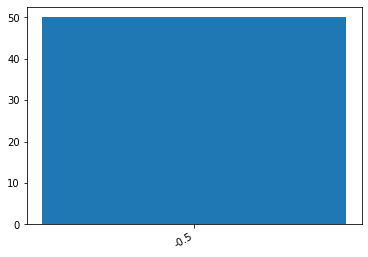

In [294]:
"""
Try inputting a question into the model by changing the `question` variable.
"""

question = "What is the value of theta^T times x plus theta_0 if theta = [1, 1] , theta_0 = negative 0.5, and x = [1, 1]^T ?"
if question[-1] not in {'.', '?'}:
    question += "?"
d = [{"expression": "", "quant_cell_positions": get_quant_cells(question), "processed_question": question, "raw_question": question}]
_, input_question_data, _, _, _, _ = setup(use_t5, test_split=1, data=d)
tensorize_data([], input_question_data)
input_question = input_question_data[0]
result = []
for i in range(50):
    pred = evaluate(input_question, model)
    test['pred_tokens'] = [out_vocab.idx2token[idx] for idx in pred]
    parse_tree = sub_nP(test['pred_tokens'], test['nP'])
#     print("parse tree:", parse_tree)
    try:
        result.append(str(evaluate_prefix_expression(parse_tree)))
    except:
        i += 1
    
counts = Counter(result)
counts = sorted(counts.items(), key=lambda x: eval(x[0]))
answers = [elt[0] for elt in sorted(counts, key=lambda x: (x[1], random.random()), reverse=True)]
print(answers)
x_ticks = [i[0] for i in counts]
freq = [i[1] for i in counts]

plt.bar(x_ticks, freq)
plt.xticks(rotation=30, horizontalalignment='right')
plt.show()

# Appendix Code (calculate percent error for each topic)

In [265]:
wrong_val_2 = []
wrong_eqn_2 = []
for elt in wrong_val:
    elt = elt.replace(",","")
    elt = elt.replace(".", "")
    elt = elt.replace(" ","")
    elt = elt.replace("negative", "")
    elt = elt.replace("-", "")
    for i in range(10):
        elt = elt.replace(str(i),"")
    wrong_val_2.append(elt)
for elt in wrong_eqn:
    elt = elt.replace(",","")
    elt = elt.replace(".", "")
    elt = elt.replace(" ","")
    elt = elt.replace("negative", "")
    elt = elt.replace("-", "")
    for i in range(10):
        elt = elt.replace(str(i),"")
    wrong_eqn_2.append(elt)

In [266]:
wrong_val_counts = dict()
wrong_eqn_counts = dict()
for elt in wrong_val_2:
    wrong_val_counts[elt] = wrong_val_counts.get(elt, 0) + 1
for elt in wrong_eqn_2:
    wrong_eqn_counts[elt] = wrong_eqn_counts.get(elt, 0) + 1

In [267]:
wrong_val_counts

{'Ifx=[]whatis||x||?': 102,
 'Ifthedecisionbounaryofaclassifieristhetawherethetaisequalto()howdoesitclassifypointpwherepisequalto()?': 125,
 'Whatisthemarginonapointwithalabelifitisclassifiedbyaclassifierwiththetaandtheta_?': 104,
 'IfaisandtiswhatistheQlearningvalueafterapplyingonetuple(sa)ifqis?': 99,
 'AneuralnetworkhasinputxwithweightwthatgoesintoneuronANeuronAalsohasinputoAthathasweightwOANeuronCinputstheoutputofneuronAwithweightwACNeuronChasalsohasinputoCthathasweightwOCNeuronsoutputthesumtheproductsofeachinputwiththeirrespectiveweightWhatistheoutputofneuronCifsiswisoAiswOAiswACisoCisandwOCis?': 512,
 'FindtheEuclidianlengthof[]': 98,
 'Letthetabe()theta_beandxbe()Computethetatimesxplustheta_': 90,
 'AneuralnetworkhasinputxwithweightwthatgoesintoneuronANeuronAalsohasinputoAthathasweightwOANeuronCinputstheoutputofneuronAwithweightwACNeuronChasalsohasinputoCthathasweightwOCNeuronCappliesaReLUonitsoutputNeuronsoutputthesumtheproductsofeachinputwiththeirrespectiveweightWhatistheoutpu

In [268]:
wrong_eqn_counts

{'Ifx=[]whatis||x||?': 108,
 'Ifthedecisionbounaryofaclassifieristhetawherethetaisequalto()howdoesitclassifypointpwherepisequalto()?': 125,
 'Whatisthemarginonapointwithalabelifitisclassifiedbyaclassifierwiththetaandtheta_?': 104,
 'IfaisandtiswhatistheQlearningvalueafterapplyingonetuple(sa)ifqis?': 99,
 'AneuralnetworkhasinputxwithweightwthatgoesintoneuronANeuronAalsohasinputoAthathasweightwOANeuronCinputstheoutputofneuronAwithweightwACNeuronChasalsohasinputoCthathasweightwOCNeuronsoutputthesumtheproductsofeachinputwiththeirrespectiveweightWhatistheoutputofneuronCifsiswisoAiswOAiswACisoCisandwOCis?': 512,
 'FindtheEuclidianlengthof[]': 98,
 'Letthetabe()theta_beandxbe()Computethetatimesxplustheta_': 90,
 'WhatisthelengthoftheresultfromapplyingFtoIifFhaslengthandIhaslength?': 96,
 'AneuralnetworkhasinputxwithweightwthatgoesintoneuronANeuronAalsohasinputoAthathasweightwOANeuronCinputstheoutputofneuronAwithweightwACNeuronChasalsohasinputoCthathasweightwOCNeuronCappliesaReLUonitsoutputNeu

In [269]:
question_to_topic = {'Whatisthemagnitudeofthevector[]?': 'b', 'Letaninputvectorbe[]Whatisitsmagnitude?': 'b', 'Ifx=[]whatis||x||?': 'b', 'Computethemagnitudeof[]': 'b', 'FindtheEuclidianlengthof[]': 'b', 'Howdoesaclassifierwithdecisionboundarythetaclassifyapointpifthetais()andpis()?': 'p', 'Aclassifierhasadecisionboundarywherethetais()Whatvaluedoesitclassifypwherepis()?': 'p', 'Ifthedecisionbounaryofaclassifieristhetawherethetaisequalto()howdoesitclassifypointpwherepisequalto()?': 'p', 'Apointpisclassifiedbyaclassifierwhosedecisionboundaryistheta=()Howdoesitclassifypwherepis()?': 'p', 'Ifthetaisthedecisionboundaryforsomeclassifierhowdoestheclassifierclassifyapointpwherethetais()andpis()?': 'p', 'Whatisthemarginofaclassifierwiththetabeingandtheta_beingonapointwithlabel?': 'f', 'Ifapointwithlabelwasclassifiedbyaclassifierwiththetaandtheta_whatisthemarginofthispoint?': 'f', 'Whatisthemarginonapointwithalabelifitisclassifiedbyaclassifierwiththetaandtheta_?': 'f', 'Whatisthesizeofthemarginofapointbyaclassifierwiththetaandtheta_ifthepointhaslabel?': 'f', 'ApointhaslabelComputethemarginofaclassifieronthispointLetthethetaoftheclassifierbeandthetheta_oftheclassifierbe': 'f', 'xis()thetais()andtheta_isWhatisthevalueofthetatimesxplustheta_?': 'lg', 'Whatisthevalueofthetatimesxplustheta_ifxis()thetais()andtheta_is?': 'lg', 'Letthetabe()theta_beandxbe()Computethetatimesxplustheta_': 'lg', 'Whatistheresultofthetatimesxplustheta_ifxis()thetais()andtheta_is?': 'lg', 'Ifwehavexequals()thetaequals()andtheta_equalsthenwhatistheresultofthetatimesxplustheta_?': 'lg', 'Iff(theta)istimesthetaplussquaredandthetaiswhatisf(theta)?': 'r', 'f(theta)isdefinedastimesthetaplussquaredandthetaisWhatisf(theta)?': 'r', 'f(theta)isthesquareofthesumofandtheproductofandwherethetaisWhatisf(theta)?': 'r', 'Whatisf(theta)iff(theta)isthetatimesplussquaredandthetais?': 'r', 'Iff(theta)istimesthetaplussquaredwhatisf(theta)whenthetais?': 'r', 'AneuralnetworkhasinputxwithweightwthatgoesintoneuronANeuronAalsohasinputoAthathasweightwOANeuronCinputstheoutputofneuronAwithweightwACNeuronChasalsohasinputoCthathasweightwOCNeuronsoutputthesumtheproductsofeachinputwiththeirrespectiveweightWhatistheoutputofneuronCifsiswisoAiswOAiswACisoCisandwOCis?': 'nn_i', 'AneuralnetworkhasinputxwithweightwthatgoesintoneuronANeuronAalsohasinputoAthathasweightwOANeuronCinputstheoutputofneuronAwithweightwACNeuronChasalsohasinputoCthathasweightwOCNeuronCappliesaReLUonitsoutputNeuronsoutputthesumtheproductsofeachinputwiththeirrespectiveweightWhatistheoutputofneuronCifsiswisoAiswOAiswACisoCisandwOCis?': 'nn_ii', 'IhaslengthandFhaslengthwhatisthelengthoftheresultofapplyingFtoI?': 'cnn', 'IislengthandFislengthWhatisthelengthoftheresultfromapplyingFtoI?': 'cnn', 'IfFhaslengthandIhaslengthwhatisthelengthoftheresultfromapplyingFtoI?': 'cnn', 'WhatisthelengthoftheresultfromapplyingFtoIifFhaslengthandIhaslength?': 'cnn', 'IfIislengthandFislengthcomputethelengthoftheoutputfromapplyingFtoI?': 'cnn', 'ConsideraverysimpleRNNdefinedbythefollowingequation:s_t=w*s_t+x_tGivens_=w=andx=[]whatiss_?': 'rnn', 'AnRNNisdefinedass_t=w*s_t+x_tIfs_iswisandxis[]whatiss_?': 'rnn', 'WhatistheRNNresults_ifs_iswisandxis[]ifwelets_t=w*s_t+x_t?': 'rnn', 'WedefineanRNNass_t=w*s_t+x_tWhatiss_ifs_iswisandxis[]?': 'rnn', 'Lets_bewbeandxbe[]Computes_ifs_tisw*s_t+x_t': 'rnn', 'Letastatemachinebedescribedwiththeequationss_t=f(s_(t)x_t)andy_t=g(s_t)wherex_tistheinputIfs_isf(s_(t)x_t)=(s_(t))m(x_t)andg(s_t)=*s_twhatistheoutputy_aftertheinputs[]?': 'sm_mdp', 'WhatistheupdatedQvalueofatuple(sa)ifqistheaisandtis?': 'rl', 'IfqiswhatisitsupdatedvalueafterapplyingQlearningifaisandtis?': 'rl', 'Letq=AfterQlearningwhatisqifaisandtis?': 'rl', 'IfaisandtiswhatistheQlearningvalueafterapplyingonetuple(sa)ifqis?': 'rl', 'AfterapplyingQlearningtoq=whatisitsvalue?Letthetbeandabe': 'rl', 'ConsideraDclassificationlineonaDplaneThereisatotalofpointsofwhichareontherightandtherestontheleftoftheboundarypointsontheleftareclassifiedpositiveWhatistheentropyoftheleftregion?': 'dtnn'}

In [270]:
topic_to_wrong_val = dict()
topic_to_wrong_eqn = dict()
for question in wrong_val_counts:
    topic = question_to_topic[question]
    topic_to_wrong_val[topic] = topic_to_wrong_val.get(topic, 0) + wrong_val_counts[question]
for question in wrong_eqn_counts:
    topic = question_to_topic[question]
    topic_to_wrong_eqn[topic] = topic_to_wrong_eqn.get(topic, 0) + wrong_eqn_counts[question]
topic_to_wrong_val_percent_correct = {k:1 - topic_to_wrong_val[k]/len(test_data) for k in topic_to_wrong_val}
topic_to_wrong_eqn_percent_correct = {k:1 - topic_to_wrong_eqn[k]/len(test_data) for k in topic_to_wrong_eqn}

# Accuracy Rates per Topic

In [271]:
print(sum([topic_to_wrong_val_percent_correct[elt] for elt in topic_to_wrong_val_percent_correct])/(len(topic_to_wrong_val_percent_correct)+1))
print(sum([topic_to_wrong_val_percent_correct[elt] for elt in topic_to_wrong_val_percent_correct])/(len(topic_to_wrong_val_percent_correct)))
topic_to_wrong_val_percent_correct

0.8497435897435898
0.9205555555555556


{'b': 0.914,
 'p': 0.9173333333333333,
 'f': 0.9183333333333333,
 'rl': 0.9443333333333334,
 'nn_i': 0.9146666666666666,
 'lg': 0.9235,
 'nn_ii': 0.915,
 'r': 0.916,
 'cnn': 0.924,
 'dtnn': 0.9161666666666667,
 'sm_mdp': 0.9173333333333333,
 'rnn': 0.926}

In [272]:
print(sum([topic_to_wrong_eqn_percent_correct[elt] for elt in topic_to_wrong_eqn_percent_correct])/(len(topic_to_wrong_eqn_percent_correct)+1))
print(sum([topic_to_wrong_eqn_percent_correct[elt] for elt in topic_to_wrong_eqn_percent_correct])/(len(topic_to_wrong_eqn_percent_correct)))
topic_to_wrong_eqn_percent_correct

0.8461538461538461
0.9166666666666666


{'b': 0.913,
 'p': 0.9173333333333333,
 'f': 0.9183333333333333,
 'rl': 0.9151666666666667,
 'nn_i': 0.9146666666666666,
 'lg': 0.9213333333333333,
 'cnn': 0.9196666666666666,
 'nn_ii': 0.915,
 'r': 0.916,
 'rnn': 0.916,
 'dtnn': 0.9161666666666667,
 'sm_mdp': 0.9173333333333333}

In [274]:
import matplotlib.pyplot as plt
import pandas as pd

Text(0, 0.5, 'Percent Correct')

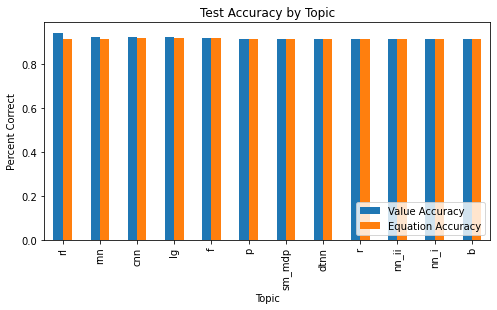

In [275]:
sorted_keys_val = sorted(tuple(topic_to_wrong_val_percent_correct),reverse=True,key=lambda x: topic_to_wrong_val_percent_correct[x])
# sorted_keys_eqn = sorted(tuple(topic_to_wrong_eqn_percent_correct),reverse=True,key=lambda x: topic_to_wrong_eqn_percent_correct[x])
plot = pd.DataFrame({"Value Accuracy": [topic_to_wrong_val_percent_correct[key] for key in sorted_keys_val],"Equation Accuracy": [topic_to_wrong_eqn_percent_correct[key] for key in sorted_keys_val]}, index=sorted_keys_val).plot(kind="bar",title="Test Accuracy by Topic",figsize=(8, 4))
plot.legend(loc="lower right")
plt.xlabel("Topic")
plt.ylabel("Percent Correct")

In [276]:
generate_plot(topic_to_wrong_val_percent_correct,"Topic to Percentage Correct (Value Accuracy)")

NameError: name 'generate_plot' is not defined

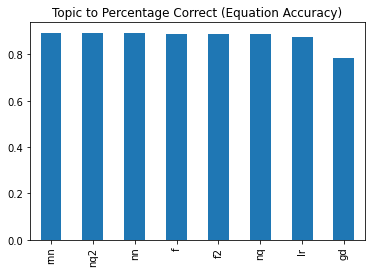

In [111]:
generate_plot(topic_to_wrong_eqn_percent_correct,"Topic to Percentage Correct (Equation Accuracy)")